In [11]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import jinja2
import os
from pathlib import Path
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest

from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
from drain3.file_persistence import FilePersistence


In [ ]:
# path = kagglehub.dataset_download("boltzmannbrain/nab")
# print("Path to dataset files: ", path)

In [2]:
load_dotenv()

True

In [3]:
# pd.read_csv(r"C:\Users\Martin James\.cache\kagglehub\datasets\boltzmannbrain\nab\versions\1\realAWSCloudwatch\realAWSCloudwatch\")
AWS_dir_path = Path(os.getenv("AWS_DIR_PATH"))
# all_AWS_paths = [os.path.join(AWS_dir_path, file) for file in os.listdir(AWS_dir_path) if file.endswith(".csv")]
all_AWS_paths = [AWS_dir_path / file for file in os.listdir(str(AWS_dir_path)) if file.endswith(".csv")]

# for my_path in all_AWS_paths:
#     print(my_path.name)

In [ ]:
AWS_name_gen = (x.name for x in all_AWS_paths)
all_AWS_df_list = [pd.read_csv(my_path) for my_path in all_AWS_paths]

for df in all_AWS_df_list:
    std_scaler = StandardScaler()
    rbst_scaler = RobustScaler()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['std_value'] = std_scaler.fit_transform(df[['value']]) # reminder that double brackets returns a df, not a series
    # df['rbst_value'] = rbst_scaler.fit_transform(df[['value']])
    # df.style.set_caption(next(AWS_name_gen, "somethingWentWrong"))
    
    display(df.tail(2).style.set_caption(next(AWS_name_gen, "somethingWentWrong")))

In [ ]:
inp_df = all_AWS_df_list[0]

In [ ]:
def run_iso(my_df, window=5, contamination="auto"):
    # window = 5
    X = []

    for i in range(len(my_df) - window):
        X.append(my_df['std_value'].iloc[i:i+window].values)

    X = np.array(X)

    iso = IsolationForest(contamination=contamination, random_state=1)
    y_pred = iso.fit_predict(X)

    # align predictions with dataframe
    my_df['anomaly_window'] = 0
    my_df.loc[window-1:, 'anomaly_window'] = np.append((y_pred == -1).astype(int), 1) # fixing the minor misalignment


In [ ]:
run_iso(inp_df, window=7)
# inp_df

In [ ]:
# inp_df.describe()
inp_df[inp_df["anomaly_window"] == 1].head()

In [43]:
plt.figure(figsize=(12,6))
plt.plot(inp_df['timestamp'], inp_df['std_value'], label='Standard-scaled Value', color='blue', zorder=1)

# Optional: highlight anomalies if you have them
anomalies = inp_df[inp_df['anomaly_window'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['std_value'], 
            color='red', label='Anomaly', marker='x', zorder=2)

plt.xlabel("Timestamp")
plt.ylabel("Standard-scaled value")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'inp_df' is not defined

<Figure size 1200x600 with 0 Axes>

## MVAD dataset

In [ ]:
merged_df = None

In [ ]:
MVAD_csv_path = Path(os.getenv("MVAD_CSV_PATH"))

if merged_df == None:
    merged_df = pd.read_csv(MVAD_csv_path)
# merged_df.head()



In [6]:
merged_df.describe()

,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly
count,2.200100e+07,2.200100e+07,2.200100e+07,2.200100e+07,2.200100e+07,2.200100e+07,1.000100e+07
mean,5.472534e+01,4.629903e+01,2.096583e+00,5.045290e+01,5.938855e+01,3.443126e+01,3.498380e-02
std,1.477406e+01,1.859389e+01,9.568915e-01,1.458640e+01,2.411135e+01,1.280995e+01,1.837388e-01
min,1.624273e+01,-1.763126e+01,-6.884508e-01,5.558192e+00,0.000000e+00,3.841720e+00,0.000000e+00
25%,4.230021e+01,3.367769e+01,1.582006e+00,3.824348e+01,3.944375e+01,2.459827e+01,0.000000e+00
50%,5.919930e+01,4.390329e+01,2.037027e+00,4.988296e+01,5.963671e+01,2.851598e+01,0.000000e+00
75%,6.605006e+01,5.610813e+01,2.503584e+00,6.178745e+01,7.982759e+01,4.403340e+01,0.000000e+00
max,1.104958e+02,1.756515e+02,9.999998e+00,1.034214e+02,1.080887e+02,8.769385e+01,1.000000e+00


In [29]:
merged_df["timestamp"] = pd.to_datetime(merged_df["timestamp"])
merged_df.head()

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly,identifier
0,2024-11-29 09:09:57.057439,41.490142,35.179593,2.336904,43.788196,99.915688,33.196576,0.0,pc1
1,2024-11-29 09:09:57.157439,39.585270,52.040069,2.012390,32.630828,100.000000,43.756880,0.0,pc1
2,2024-11-29 09:09:57.257439,41.943191,49.847277,2.148926,40.297797,96.634885,43.539590,0.0,pc1
3,2024-11-29 09:09:57.357439,44.569278,40.875797,1.232071,36.102717,100.000000,35.868198,0.0,pc1
4,2024-11-29 09:09:57.457439,39.297791,19.345670,2.673152,34.724144,89.363255,28.023581,0.0,pc1


In [ ]:
# merged_df[merged_df['anomaly']==nan].count()
# merged_df[(merged_df['anomaly'].isna()) & (merged_df["identifier"]=="pc2")]
pc2_df = merged_df[(merged_df["identifier"]=="pc2")]
pc2_df.head()

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly,identifier
10001000,2024-11-29 22:33:51.356533,66.210862,38.599980,2.059690,51.048539,99.905166,22.321152,NaN,pc2
10001001,2024-11-29 22:33:51.456533,67.818980,35.366672,2.049953,72.119658,102.105780,26.392518,NaN,pc2
10001002,2024-11-29 22:33:51.556533,62.822901,56.445725,1.586319,95.334475,97.268314,19.998402,NaN,pc2
10001003,2024-11-29 22:33:51.656533,76.247971,39.339458,1.200303,52.663749,98.256837,29.819617,NaN,pc2
10001004,2024-11-29 22:33:51.756533,57.955404,18.315938,1.701509,42.556337,103.787326,23.614287,NaN,pc2


In [33]:
pc1_df = merged_df[merged_df["identifier"] == "pc1"]
pc1_df.describe()

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly
count,10001000,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07
mean,2024-12-05 04:02:27.017411328,4.174923e+01,5.275351e+01,2.072775e+00,3.749818e+01,5.980185e+01,4.499914e+01,3.498380e-02
min,2024-11-29 09:09:57.057439,1.624273e+01,5.672135e-04,6.718557e-07,5.558192e+00,0.000000e+00,3.841720e+00,0.000000e+00
25%,2024-12-02 06:35:22.032439040,3.369778e+01,3.737820e+01,1.404004e+00,3.296143e+01,3.998035e+01,3.686457e+01,0.000000e+00
50%,2024-12-05 04:02:27.007438848,4.077639e+01,5.141025e+01,2.104504e+00,3.750030e+01,6.000550e+01,4.499574e+01,0.000000e+00
75%,2024-12-08 01:29:31.982438912,4.747996e+01,6.549397e+01,2.741236e+00,4.203734e+01,8.002154e+01,5.312889e+01,0.000000e+00
max,2024-12-10 22:56:36.957439,1.104958e+02,1.756515e+02,5.443351e+00,7.283221e+01,1.000000e+02,8.769385e+01,1.000000e+00
std,NaN,1.099282e+01,2.115173e+01,8.659950e-01,6.612515e+00,2.407556e+01,1.081496e+01,1.837388e-01


In [40]:
std_scaler_pc1 = StandardScaler()
scalable_columns = ["cpu_temperature", "cpu_usage", "cpu_load", "memory_usage", "battery_level", "cpu_power"]
pc1_scaled = pd.DataFrame(std_scaler_pc1.fit_transform(pc1_df[scalable_columns]), columns=scalable_columns, index=pc1_df.index)
pc1_scaled["timestamp"] = pc1_df["timestamp"]
pc1_scaled["anomaly"] = pc1_df["anomaly"]


In [41]:
reordered_columns = ["timestamp"]
reordered_columns.extend(scalable_columns)
reordered_columns.extend(["anomaly"])
# reordered_columns
pc1_scaled = pc1_scaled[reordered_columns]
# pc1_scaled.head(2)

In [42]:
display(pc1_scaled.head())
pc1_scaled.describe()

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly
0,2024-11-29 09:09:57.057439,-0.023569,-0.830850,0.305001,0.951229,1.666164,-1.091318,0.0
1,2024-11-29 09:09:57.157439,-0.196852,-0.033730,-0.069729,-0.736082,1.669666,-0.114865,0.0
2,2024-11-29 09:09:57.257439,0.017644,-0.137399,0.087935,0.423381,1.529893,-0.134956,0.0
3,2024-11-29 09:09:57.357439,0.256535,-0.561548,-0.970795,-0.211034,1.669666,-0.844288,0.0
4,2024-11-29 09:09:57.457439,-0.223004,-1.579438,0.693280,-0.419513,1.227859,-1.569636,0.0


,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power,anomaly
count,10001000,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07,1.000100e+07
mean,2024-12-05 04:02:27.017411328,-7.558643e-15,1.502582e-15,1.668028e-15,-5.357468e-16,6.770693e-15,-7.323628e-15,3.498380e-02
min,2024-11-29 09:09:57.057439,-2.320288e+00,-2.494026e+00,-2.393517e+00,-4.830234e+00,-2.483924e+00,-3.805600e+00,0.000000e+00
25%,2024-12-02 06:35:22.032439040,-7.324282e-01,-7.269059e-01,-7.722572e-01,-6.860859e-01,-8.233040e-01,-7.521585e-01,0.000000e+00
50%,2024-12-05 04:02:27.007438848,-8.849822e-02,-6.350603e-02,3.663928e-02,3.201381e-04,8.458594e-03,-3.140362e-04,0.000000e+00
75%,2024-12-08 01:29:31.982438912,5.213152e-01,6.023365e-01,7.719004e-01,6.864503e-01,8.398429e-01,7.517134e-01,0.000000e+00
max,2024-12-10 22:56:36.957439,6.253768e+00,5.810308e+00,3.892143e+00,5.343509e+00,1.669666e+00,3.947744e+00,1.000000e+00
std,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.837388e-01


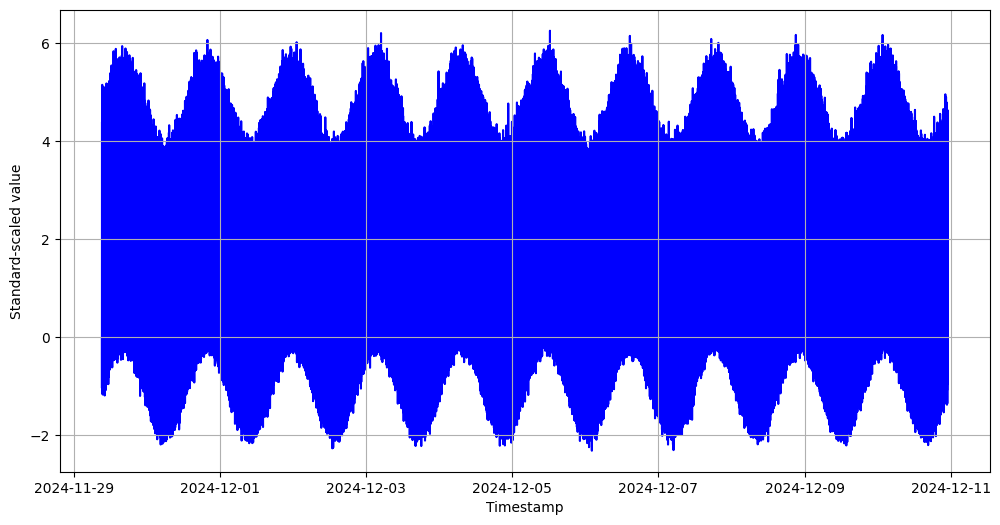

In [45]:
plt.figure(figsize=(12,6))
plt.plot(pc1_scaled['timestamp'], pc1_scaled['cpu_temperature'], label='Standard-scaled Value of cpu_temperature', color='blue', zorder=1)

# Optional: highlight anomalies if you have them
# anomalies = inp_df[inp_df['anomaly_window'] == 1]
# plt.scatter(anomalies['timestamp'], anomalies['std_value'], 
#             color='red', label='Anomaly', marker='x', zorder=2)

plt.xlabel("Timestamp")
plt.ylabel("Standard-scaled value")
# plt.legend()
plt.grid(True)
plt.show()

In [54]:
small_slice = pc1_df[pc1_df["timestamp"] < pd.Timestamp("2024-12-02")]
# small_slice.count()

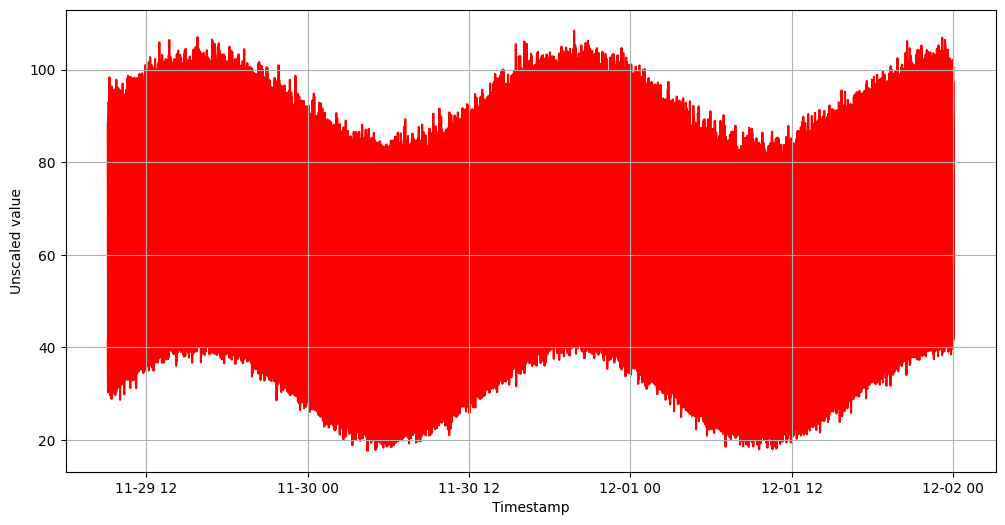

In [55]:
plt.figure(figsize=(12,6))
plt.plot(small_slice['timestamp'], small_slice['cpu_temperature'], label='Value of cpu_temperature', color='red', zorder=1)

# Optional: highlight anomalies if you have them
# anomalies = inp_df[inp_df['anomaly_window'] == 1]
# plt.scatter(anomalies['timestamp'], anomalies['std_value'], 
#             color='red', label='Anomaly', marker='x', zorder=2)

plt.xlabel("Timestamp")
plt.ylabel("Unscaled value")
# plt.legend()
plt.grid(True)
plt.show()

In [58]:
small_slice_pc2 = pc2_df[pc2_df["timestamp"] < pd.Timestamp("2024-11-30")]

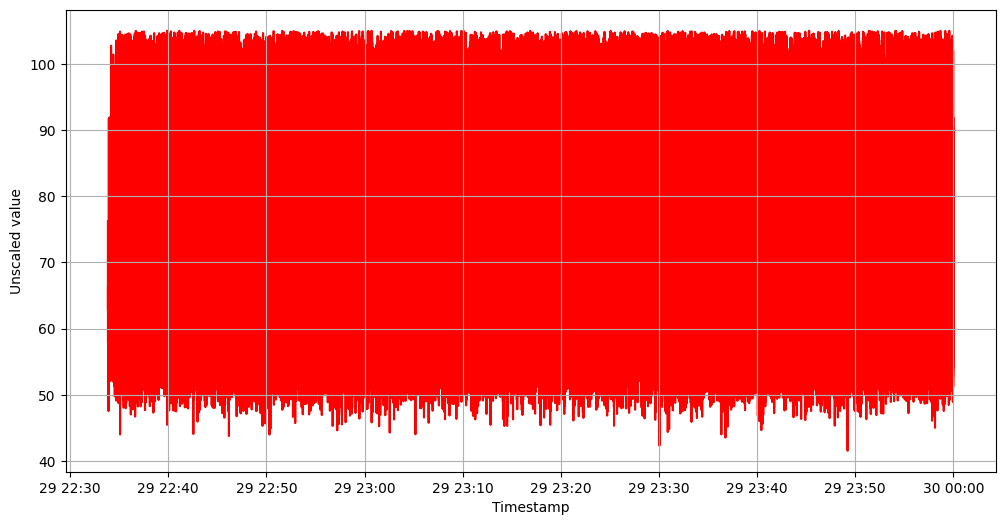

In [60]:
plt.figure(figsize=(12,6))
plt.plot(small_slice_pc2['timestamp'], small_slice_pc2['cpu_temperature'], label='Value of cpu_temperature', color='red', zorder=1)

plt.xlabel("Timestamp")
plt.ylabel("Unscaled value")
# plt.legend()
plt.grid(True)
plt.show()

## After clarification of input data, log-parsing attempt


In [16]:
import re
log_pattern = re.compile(r'^(?P<proc>\S+)\[(?P<pid>\d+)\]:\s+(?P<rest>.*)$') # (?P<ourCustomName>...) is a way in python 
                                                                         # regex to get named capturing groups  

config = TemplateMinerConfig()
persistence = FilePersistence("drain3_state.bin")
template_miner = TemplateMiner(persistence, config)


In [17]:
with open("exampleLog.txt", "r") as f:
    for line in f:
        # print(line.strip())
        parts = line.split(maxsplit=4)  

        date = f"{parts[0]} {parts[1]}"
        time = parts[2]
        node = parts[3]

        # Step 2: regex for proc/pid/message

        match = log_pattern.match(parts[4])

        if match:
            msg = match.group("rest") 
            result = template_miner.add_log_message(msg)
            print("Template:", result["template_mined"])
            parsed = {
                "date": date,
                "time": time,
                "node": node,
                "proc": match.group("proc"),
                "pid": int(match.group("pid")),
                "rest": match.group("rest")
            }
            print(parsed)

Template: E0808 00:28:17 3151 DNS.GO:153] "Nameserver limits exceeded" err="Nameserver limits were exceeded, some nameservers have been omitted, the applied nameserver line is: 10.32.4.3 10.32.4.4 10.18.51.11"
{'date': 'Aug 08', 'time': '00:28:17', 'node': 'worker-1.jawwy-ocs-prod01.stc.com.sa', 'proc': 'kubenswrapper', 'pid': 3151, 'rest': 'E0808 00:28:17 3151 DNS.GO:153] "Nameserver limits exceeded" err="Nameserver limits were exceeded, some nameservers have been omitted, the applied nameserver line is: 10.32.4.3 10.32.4.4 10.18.51.11"'}
Template: on-prem-resolv-prepender.service: Scheduled restart job, restart counter is at 16092
{'date': 'Aug 08', 'time': '00:28:17', 'node': 'worker-1.jawwy-ocs-prod01.stc.com.sa', 'proc': 'systemd', 'pid': 1, 'rest': 'on-prem-resolv-prepender.service: Scheduled restart job, restart counter is at 16092    '}
Template: E0808 <*> 3151 DNS.GO:153] "Nameserver limits exceeded" err="Nameserver limits were exceeded, some nameservers have been omitted, the